In [1]:
from datasets import load_dataset

ds = load_dataset("Yahaira/anemia-eyes")

C:\Users\Dheena Krishna\.conda\envs\Hackzilla\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import numpy as np
import os

In [3]:
def save_split(split, path):
    os.makedirs(path, exist_ok=True)
    for i, row in enumerate(split):
        label = str(row["label"])  
        class_path = os.path.join(path, label)
        os.makedirs(class_path, exist_ok=True)
        row["image"].save(os.path.join(class_path, f"{i}.jpg"))

In [ ]:
save_split(ds["train"], "data/train")
if "test" in ds:  # some datasets may only have train/validation
    save_split(ds["test"], "data/test")

In [20]:
if "validation" in ds:
    save_split(ds["validation"],"data/validation")

# Create TF Datasets

In [5]:
IMG_SIZE = (299, 299) 
BATCH_SIZE = 16

In [6]:
train_ds = image_dataset_from_directory(
    "data/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
class_names = train_ds.class_names
num_classes = len(class_names)

Found 175 files belonging to 2 classes.


In [21]:
test_ds = image_dataset_from_directory(
    "data/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 23 files belonging to 2 classes.


In [8]:
val_ds = image_dataset_from_directory(
    "data/validation",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 23 files belonging to 2 classes.


# Improve performance with caching + prefetch

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Build Xception model

In [10]:
base_model = Xception(
    weights="imagenet", 
    include_top=False, 
    input_shape=(299, 299, 3)
)
base_model.trainable = False 

In [11]:
inputs = layers.Input(shape=(299, 299, 3))
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("xception_best_model.h5", save_best_only=True)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
11/11 [==============================] - 12s 446ms/step - loss: 0.8447 - accuracy: 0.4343 - val_loss: 0.7425 - val_accuracy: 0.3913
Epoch 2/10
11/11 [==============================] - 3s 320ms/step - loss: 0.7303 - accuracy: 0.4743 - val_loss: 0.6888 - val_accuracy: 0.3913
Epoch 3/10
11/11 [==============================] - 3s 313ms/step - loss: 0.7067 - accuracy: 0.5600 - val_loss: 0.6793 - val_accuracy: 0.5652
Epoch 4/10
11/11 [==============================] - 4s 339ms/step - loss: 0.6946 - accuracy: 0.5200 - val_loss: 0.6741 - val_accuracy: 0.6087
Epoch 5/10
11/11 [==============================] - 3s 311ms/step - loss: 0.6693 - accuracy: 0.5886 - val_loss: 0.6664 - val_accuracy: 0.6087
Epoch 6/10
11/11 [==============================] - 3s 307ms/step - loss: 0.6782 - accuracy: 0.5657 - val_loss: 0.6594 - val_accuracy: 0.6087
Epoch 7/10
11/11 [==============================] - 4s 333ms/step - loss: 0.6745 - accuracy: 0.5771 - val_loss: 0.6542 - val_accuracy: 0.6087
Epoch

# Training

In [14]:
# Unfreeze last few layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
11/11 [==============================] - 8s 483ms/step - loss: 0.6298 - accuracy: 0.6286 - val_loss: 0.6370 - val_accuracy: 0.6522
Epoch 2/10
11/11 [==============================] - 4s 362ms/step - loss: 0.6260 - accuracy: 0.6229 - val_loss: 0.6365 - val_accuracy: 0.6522
Epoch 3/10
11/11 [==============================] - 4s 356ms/step - loss: 0.6148 - accuracy: 0.6229 - val_loss: 0.6359 - val_accuracy: 0.6522
Epoch 4/10
11/11 [==============================] - 4s 338ms/step - loss: 0.6385 - accuracy: 0.6457 - val_loss: 0.6354 - val_accuracy: 0.6522
Epoch 5/10
11/11 [==============================] - 3s 325ms/step - loss: 0.6381 - accuracy: 0.6171 - val_loss: 0.6349 - val_accuracy: 0.6957
Epoch 6/10
11/11 [==============================] - 3s 324ms/step - loss: 0.6324 - accuracy: 0.6286 - val_loss: 0.6342 - val_accuracy: 0.6957
Epoch 7/10
11/11 [==============================] - 4s 328ms/step - loss: 0.6390 - accuracy: 0.6343 - val_loss: 0.6339 - val_accuracy: 0.6957
Epoch 

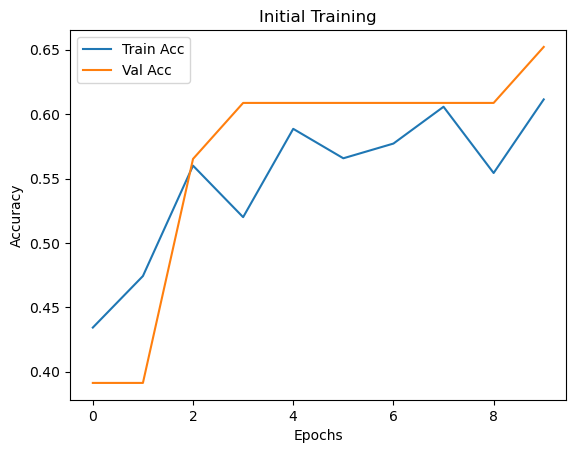

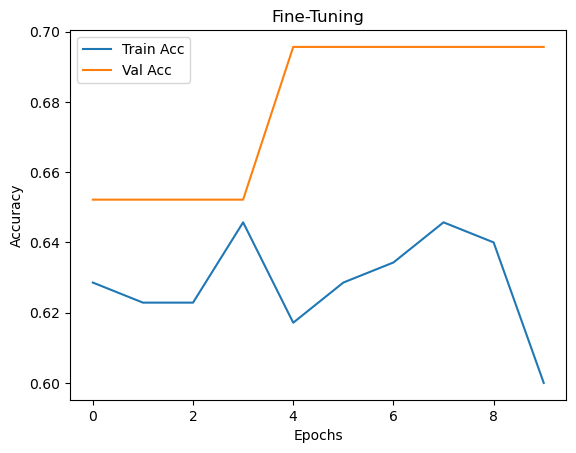

In [15]:
import matplotlib.pyplot as plt

def plot_history(hist, title="Training History"):
    plt.plot(hist.history["accuracy"], label="Train Acc")
    plt.plot(hist.history["val_accuracy"], label="Val Acc")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_history(history, "Initial Training")
plot_history(history_finetune, "Fine-Tuning")

# Testing an Image

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # Resize to Xception input
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [17]:
def predict_image(model, img_path, class_names):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence


In [18]:
img_path = "74.jpg"
predicted_class, confidence = predict_image(model, img_path, class_names)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")


1/1 [==============================] - 1s 1s/step
Predicted Class: 1
Confidence: 0.56


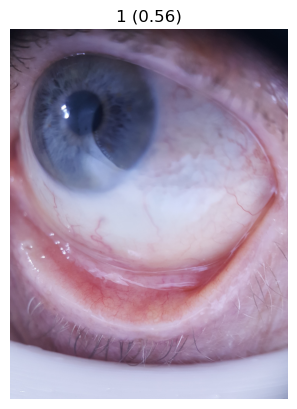

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f"{predicted_class} ({confidence:.2f})")
plt.axis('off')
plt.show()

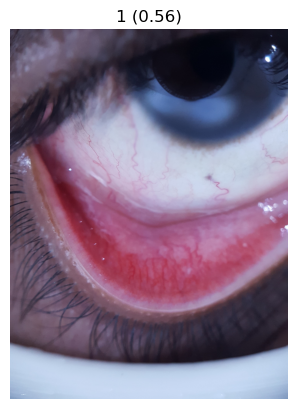

In [25]:
img_path2= "0.jpg"
img = mpimg.imread(img_path2)
plt.imshow(img)
plt.title(f"{predicted_class} ({confidence:.2f})")
plt.axis('off')
plt.show()